# Low Rank Matrix Factorization

## Formulation
Let's assume that our system has $I_{user}$ users and $J_{movie}$ movies. We assign $K_{latent}$ features to each user and movie in the system. We can construct a matrix factorization as follows:

$$
\begin{vmatrix}
x_{0,0} & x_{0,1} & x_{0, 2} & ... & x_{0, K} \\
x_{1,0} & ...     & ...      & ... & ...      \\
x_{2,0} & ...     & ...      & ... & ...      \\
...     & ...     & ...      & ... & ...      \\
x_{I,0} & ...     & ...      & ... & x_{I, K}
\end{vmatrix}
\begin{vmatrix}
\theta_{0,0} & \theta_{0,1} & \theta_{0, 2} & ... & \theta_{0, K} \\
\theta_{1,0} & ...     & ...      & ... & ...      \\
\theta_{2,0} & ...     & ...      & ... & ...      \\
...     & ...     & ...      & ... & ...      \\
\theta_{J,0} & ...     & ...      & ... & \theta_{J, K}
\end{vmatrix}^{T}
=
\begin{vmatrix}
r_{0,0} & r_{0,1} & r_{0, 2} & ... & r_{0, J} \\
r_{1,0} & ...     & ...      & ... & ...      \\
r_{2,0} & ...     & ...      & ... & ...      \\
...     & ...     & ...      & ... & ...      \\
r_{I,0} & ...     & ...      & ... & r_{I, J}
\end{vmatrix}
$$

$X$ represents the latent feature matrix for all users in our system. $\Theta$ represents the latent feature matrix for all all movies in our system. The matrix product of $X$ and $\Theta^{T}$ is the model predicated rating. 

$$
X\Theta^{T} = \hat{R}
$$

Let $R$ represents the actual rating we received from the MovieLens dataset. For every missing value in $R$, we will place them with average rating each movie received from the poll of users. Then we define the loss function as follows:

$$
L_{X, \Theta} = \frac{1}{2}\Sigma_{i,j} (X\Theta^{T} - R)^{2} + \frac{\lambda}{2}\Sigma_{i, k}X^{2} + \frac{\lambda}{2}\Sigma_{j, k}\Theta^{2}
$$

The optimization objective here is to minimize the loss function above.

## Partial Derivatives & Gradients

Recall that the output of our low-rank matrices model is $\hat{R}$ and let's find the gradient of $L$ with respect to $\hat{R}$ first. The $\frac{1}{2}$ term will get canceled out by the square term.

$$
\frac{\partial L}{\partial \hat{R}} = \hat{R} - R
$$

$$
\hat{R} = X\Theta^{T}
$$

Now let's figure out the gradient of $\hat{R}$ with respect to $X$ and $\Theta$:

$$
\frac{\partial \hat{R}}{\partial X} = \Theta^{T}
$$

$$
\frac{\partial \hat{R}}{\partial \Theta} = X
$$

Using chain rule, we can then derive the following results:

$$
\frac{\partial L}{\partial X} = \frac{\partial L}{\partial \hat{R}}\frac{\partial \hat{R}}{\partial X}
$$

$$
\frac{\partial L}{\partial \Theta} = \frac{\partial L}{\partial \hat{R}}\frac{\partial \hat{R}}{\partial \Theta}
$$

### Python
```python
"""Denote U as the user latent feature matrix and M as the movie latent feature matrix"""
model_pred = np.dot(U, M.T)

grad_pred = model_pred - R 
grad_u = np.dot(grad_pred, M) + (reg * U)
grad_m = np.dot(grad_pred.T, U) + (reg * M)
```

## Implementation

In [1]:
import numpy as np


def loss(U, M, R, reg=0.0):
    """Compute loss
    
    :param U: User latent feature matrix, there are I movies and K features
    :type U: numpy 2-d array
    :param M: Movie latent feature matrix, there are J movies and K features
    :type M: numpy 2-d array
    :param R: Rating matrix, i-index represents user and j-index represents movie
    :type R: numpy 2-d array
    :param reg: Regularization strength
    :type reg: float
    """
    diff = np.dot(U, M.T) - R
    loss = 0.5 * np.sum(diff * diff)
    loss += reg * np.sum(U * U) / 2
    loss += reg * np.sum(M * M) / 2
    return loss


def rel_error(X, Y):
    """Compute maximum relative error
    
    :param X: Matrix of the same shape as Y
    :type X: numpy array
    :param Y: Matrix of the same shape as X
    :type Y: numpy array
    """
    return np.max(np.abs(X - Y) / (np.maximum(1e-8, np.abs(X) + np.abs(Y))))


def compute_grad(U, M, R, reg=0.0):
    """Compute gradients for U and M
    
    :param U: User latent feature matrix, there are I movies and K features
    :type U: numpy 2-d array
    :param M: Movie latent feature matrix, there are J movies and K features
    :type M: numpy 2-d array
    :param R: Rating matrix, i-index represents user and j-index represents movie
    :type R: numpy 2-d array
    :param reg: Regularization strength
    :type reg: float
    """
    u_grad = np.zeros(U.shape)
    m_grad = np.zeros(M.shape)
    
    num_user, lat_dim = U.shape
    num_movie, lat_dim = M.shape
    
    diff = np.dot(U, M.T) - R
    for i in range(num_user):
        u_grad[i] = np.sum(diff[i].reshape(num_movie, 1) * M, axis=0) + (reg * U[i])

    for j in range(num_movie):
        m_grad[j] = np.sum(diff.T[j].reshape(num_user, 1) * U, axis=0) + (reg * M[j])
        
    return u_grad, m_grad


def compute_grad_vectorized(U, M, R, reg=0.0):
    """Compute gradients for U and M
    
    :param U: User latent feature matrix, there are I movies and K features
    :type U: numpy 2-d array
    :param M: Movie latent feature matrix, there are J movies and K features
    :type M: numpy 2-d array
    :param R: Rating matrix, i-index represents user and j-index represents movie
    :type R: numpy 2-d array
    :param reg: Regularization strength
    :type reg: float
    """
    grad_out = np.dot(U, M.T) - R 
    grad_u = np.dot(grad_out, M)+ (reg * U)
    grad_m = np.dot(grad_out.T, U) + (reg * M)
    return grad_u, grad_m


def compute_num_grad(U, M, R, loss_func, reg=0.0, h=1e-5):
    """Compute numerical gradients for U and M
    
    :param U: User latent feature matrix, there are I movies and K features
    :type U: numpy 2-d array
    :param M: Movie latent feature matrix, there are J movies and K features
    :type M: numpy 2-d array
    :param R: Rating matrix, i-index represents user and j-index represents movie
    :type R: numpy 2-d array
    :param reg: Regularization strength
    :type reg: float
    """
    num_grad_u = np.zeros(U.shape)
    num_grad_m = np.zeros(M.shape)
    
    U_dim, L_dim = U.shape
    M_dim, L_dim = M.shape
    
    for i in range(U_dim):
        for k in range(L_dim):
            old_val = U[i][k]
            
            U[i][k] = old_val + h
            fuph = loss_func(U, M, R, reg)
            
            U[i][k] = old_val - h
            fumh = loss_func(U, M, R, reg)
            
            U[i][k] = old_val
            num_grad_u[i][k] = (fuph - fumh) / (2 * h)
    
    for j in range(M_dim):
        for k in range(L_dim):
            old_val = M[j][k]
            
            M[j][k] = old_val + h
            fmph = loss_func(U, M, R, reg)
            
            M[j][k] = old_val - h
            fmmh = loss_func(U, M, R, reg)
            
            M[j][k] = old_val
            num_grad_m[j][k] = (fmph - fmmh) / (2 * h)
    
    return num_grad_u, num_grad_m

## Test

In [104]:
num_user = 5
num_movie = 10
lat_dim = 10
reg = 0.1

np.random.seed(0)
R = np.random.rand(num_user, num_movie) * 5
U = np.random.rand(num_user, lat_dim)
M = np.random.randn(num_movie, lat_dim)

np.dot(U, M.T)

grad_u, grad_m = compute_grad(U, M, R, reg)
num_grad_u, num_grad_m = compute_num_grad(U, M, R, loss, reg)

print "\nIterative implementation\n"                                                                                                                                                                                                                
print "Gradient of U relative error %s" % str(rel_error(grad_u, num_grad_u))
print "Gradient of M relative error %s" % str(rel_error(grad_m, num_grad_m))

print "\nFully vectorized implementation\n"
grad_u, grad_m = compute_grad_vectorized(U, M, R, reg)
print "Gradient of U relative error %s" % str(rel_error(grad_u, num_grad_u))
print "Gradient of M relative error %s" % str(rel_error(grad_m, num_grad_m))


Iterative implementation

Gradient of U relative error 1.5257047735033336e-09
Gradient of M relative error 1.7025272054379865e-09

Fully vectorized implementation

Gradient of U relative error 1.5257045748323983e-09
Gradient of M relative error 1.7025272054379865e-09


## Training

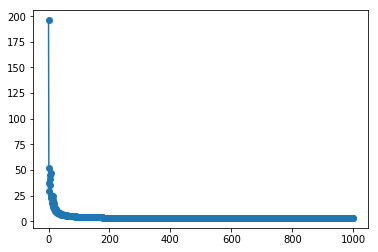

Model Prediction:
[[2.74453558 3.5730624  3.0013782  2.72495306 2.07634872 3.22343667
  2.16867417 4.40479659 4.75925313 1.95241956]
 [3.93110101 2.65246219 2.81375603 4.58581008 0.35362361 0.4780791
  0.12669202 4.14591792 3.86561675 4.29266286]
 [4.83346695 3.95758285 2.31372635 3.87466965 0.60928358 3.15844329
  0.72523497 4.68932701 2.63658184 2.08560523]
 [1.35017893 3.83396737 2.28135232 2.82940949 0.1291836  3.05680769
  3.0107386  3.0909186  4.68444611 3.36702171]
 [1.78355249 2.173264   3.43614197 0.32010237 3.2775662  3.31310629
  1.05220428 0.67575537 1.58832707 1.79163532]]


Actual Rating:
[[2.74406752 3.57594683 3.01381688 2.72441591 2.118274   3.22947057
  2.18793606 4.458865   4.8183138  1.91720759]
 [3.95862519 2.6444746  2.84022281 4.62798319 0.35518029 0.4356465
  0.10109199 4.16309923 3.89078375 4.35006074]
 [4.89309171 3.99579282 2.30739681 3.90264588 0.59137213 3.19960511
  0.71676644 4.72334459 2.60924161 2.0733097 ]
 [1.32277806 3.87116845 2.28075166 2.84216974 

In [105]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

steps = 1000
learning_rate = 5e-2
losses = []

for step in range(steps):
    losses.append(loss(U, M, R, reg))
    grad_u, grad_m = compute_grad(U, M, R, reg)
    U = U - learning_rate * grad_u
    M = M - learning_rate * grad_m
    
plt.plot(list(range(steps)), losses, 'o-')
plt.show()

print "Model Prediction:"
print np.dot(U, M.T)

print "\n"

print "Actual Rating:"
print R

## Given a new user

Suppose that we are given a new user, we can perform the same type of training on this user except that we are not modifying the movie features; we will only modify the new user's preference vector.

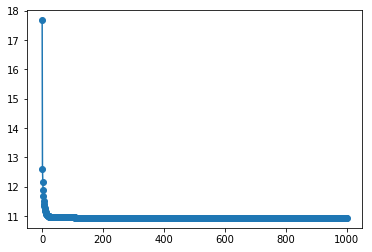

Model Prediction:
[[ 0.71172833  1.02241052  1.71358824 -0.02672381  2.17991451  1.69306215
   0.82948497  0.9881572   1.50015334  0.15329032]]


Actual Rating:
[[2.03620586 1.16117071 0.66243817 0.26713591 3.62797182 0.05713729
  3.85290374 0.73473323 0.39761041 0.44801517]]


In [109]:
single_user_matrix = np.random.rand(1, lat_dim)
single_user_rating = np.random.rand(1, num_movie) * 5
losses = []
learning_rate = 5e-2

steps = 1000
for step in range(steps):
    losses.append(loss(single_user_matrix, M, single_user_rating, reg))
    grad_u, _ = compute_grad(single_user_matrix, M, single_user_rating, reg)
    single_user_matrix = single_user_matrix - learning_rate * grad_u
    
plt.plot(list(range(steps)), losses, 'o-')
plt.show()

print "Model Prediction:"
print np.dot(single_user_matrix, M.T)

print "\n"

print "Actual Rating:"
print single_user_rating

After all this is a linear model, it does have difficulty with fitting random data perfectly.